In [19]:
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from bertopic import BERTopic
from textblob import TextBlob

/home/milos/.cache/pypoetry/virtualenvs/dissertation-53o3-k0o-py3.11/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/milos/.cache/pypoetry/virtualenvs/dissertation-53o3-k0o-py3.11/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/h

In [20]:
df = pd.read_csv('../datasets/tweets_generated.csv', header=None)
df.columns = ['category', 'sentiment', 'text']
df.head()

,category,sentiment,text
0,healthcare,very_positive,I am constantly amazed by the high quality of ...
1,healthcare,slightly_positive,The healthcare system in the Czech Republic ma...
2,healthcare,very_positive,I am constantly amazed by the top-notch health...
3,healthcare,slightly_positive,"Despite some challenges, I am impressed by the..."
4,healthcare,very_positive,Proud to see the Czech Republic's healthcare s...


In [21]:
nltk.download('stopwords')
texts_clean = df['text']

replacements = [
    ("it's", "it is"),
    ("#", ''),
    (r"[^\w\s]", ''),
    (r"\s+", ' '),
    ('dont', 'do not'),
    ('im', 'i am'),
    ('theres', 'there is'),
    ('thats', 'that is'),
    ('youre', 'you are'),
    ('doesnt', 'does not'),
    ('didnt', 'did not'),
    ('cant', 'can not'),
    ('couldnt', 'could not')
]

for replacement in replacements:
    texts_clean = [re.sub(replacement[0], replacement[1], t) for t in texts_clean]

stopwords_en = nltk.corpus.stopwords.words('english')
texts_no_sw = [' '.join([w for w in t.split() if w not in stopwords_en])
               for t in texts_clean if 'holytrainer' not in t]

[nltk_data] Downloading package stopwords to /home/milos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
topic_model = BERTopic(
    language='english', top_n_words=2, n_gram_range=(1, 2), 
    min_topic_size=3, nr_topics=2, calculate_probabilities=True, verbose=False)
topic_model.fit(texts_no_sw)
print(topic_model.get_topics())
print(topic_model.probabilities_)

{0: [('education', 0.15647100754039794), ('czech republic', 0.07502609494499653)], 1: [('healthcare', 0.09523576818406176), ('czech', 0.08277698622529735)]}
[[2.04633143e-001 7.35344254e-001]
 [2.80576974e-001 7.07178216e-001]
 [4.33767665e-309 1.00000000e+000]
 [2.06326276e-001 7.33651120e-001]
 [3.45453765e-001 5.83192479e-001]
 [2.06617554e-001 7.85665677e-001]
 [4.39358902e-309 1.00000000e+000]
 [2.25571478e-001 5.94809629e-001]
 [5.13371738e-309 1.00000000e+000]
 [4.19162591e-001 5.09483653e-001]
 [3.25508405e-001 6.03137838e-001]
 [3.62310862e-001 4.20784763e-001]
 [1.00000000e+000 4.41479798e-309]
 [1.00000000e+000 4.54693130e-309]
 [1.00000000e+000 4.90015890e-309]
 [7.80395628e-001 2.01827153e-001]
 [5.19584591e-001 2.30275472e-001]]


In [39]:
topic_model.probabilities_.sum(axis=0)

array([6.87614127, 9.10535025])

In [12]:
sentiments = []
mask = []

for t in df['text'][:-3]:
    if 'holytrainer' in t.lower():
        continue
    polarity = TextBlob(t).sentiment.polarity
    sentiments.append(polarity)
    if abs(polarity) < 0.05:
        mask.append([0])
    else:
        mask.append([1])

sentiments = np.array(sentiments).reshape(-1, 1)
sentiments

array([[0.30533333],
       [0.11363636],
       [0.42      ],
       [0.31944444],
       [0.585     ],
       [0.        ],
       [0.66666667],
       [0.66666667],
       [0.33333333]])

In [13]:
mean_sentiments = (sentiments * np.array(mask)).sum(axis=0) / np.array(mask).sum(axis=0)
mean_sentiments[:5]

array([0.4262601])

In [14]:
def semivariance(data, mean: np.ndarray, probas: np.ndarray, side):
    semivariances = []
    for i in range(len(mean)):
        if side == 'left':
            semi_data = data[data < mean[i]]
            semi_probas = probas[(data < mean[i]).reshape(-1), i]
        else:
            semi_data = data[data > mean[i]]
            semi_probas = probas[(data > mean[i]).reshape(-1), i]
        nominator = (((semi_data - mean[i]) ** 2) * semi_probas).sum(axis=0)
        denominator = semi_probas.sum(axis=0)
        result = np.sqrt(nominator / denominator)
        semivariances.append(result)
    return semivariances

In [15]:
semivariance_left = semivariance(sentiments, mean_sentiments, np.array(mask), 'left')
semivariance_right = semivariance(sentiments, mean_sentiments, np.array(mask), 'right')

semivariance_left, semivariance_right

([0.16275198420500767], [0.21663255307308776])

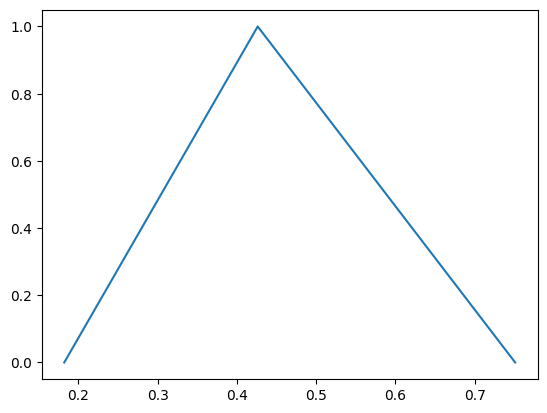

In [16]:
plt.plot([mean_sentiments[0] - semivariance_left[0] * 1.5, mean_sentiments[0], mean_sentiments[0] +
          semivariance_right[0] * 1.5], [0, 1, 0])
plt.show()

In [17]:
def conformity_positive(answer_fuzzy, neg_a, neg_b):
    if answer_fuzzy[1] >= neg_b:
        possibility = 1
    elif answer_fuzzy[2] <= neg_a:
        possibility = 0
    else:
        x = (neg_a * answer_fuzzy[1] - answer_fuzzy[2] * neg_b) / \
            (neg_a - neg_b + answer_fuzzy[1] - answer_fuzzy[2])
        possibility = (x - neg_a) / (neg_b - neg_a)
    return possibility


def conformity_negative(answer_fuzzy, pos_a, pos_b):
    answer_fuzzy_rev = (- answer_fuzzy[2], - answer_fuzzy[1], - answer_fuzzy[0])
    return conformity_positive(answer_fuzzy_rev, pos_b, pos_a)



In [18]:
con_pos = conformity_positive([mean_sentiments[0] - semivariance_left[0] * 1.5, mean_sentiments[0], mean_sentiments[0] +
                               semivariance_right[0] * 1.5], -0.32, 1)
con_neg = conformity_negative([mean_sentiments[0] - semivariance_left[0] * 1.5, mean_sentiments[0], mean_sentiments[0] +
                               semivariance_right[0] * 1.5], 1, -0.75)
con_pos, con_neg

(0.6512110962588087, 0.28477002581796207)